## CS4200 Project: Human Action Recognition Classification Project

First, going to import required libraries and import the data obtained from Kaggle obtained here: https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset/data

In [ ]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split

# Obtain training data
train_set_path = "Human Action Recognition/Training_set.csv"
train_df = pd.read_csv(train_set_path)

# Store the original categories
categories = train_df['label'].astype('category').cat.categories

# Label encoding:
# 0 = calling, 1 = clapping, 2 = cycling, 3 = dancing, 4 = drinking,
# 5 = eating, 6 = fighting, 7 = hugging, 8 = laughing, 9 = listening to music
# 10 = running, 11 = sitting, 12 = sleeping, 13 = texting, 14 = using_laptop 

In [20]:
categories

Index(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating',
       'fighting', 'hugging', 'laughing', 'listening_to_music', 'running',
       'sitting', 'sleeping', 'texting', 'using_laptop'],
      dtype='object')

### Checking the training and testing set data:

In [21]:
train_df

filename               label
0          Image_1.jpg             sitting
1          Image_2.jpg        using_laptop
2          Image_3.jpg             hugging
3          Image_4.jpg            sleeping
4          Image_5.jpg        using_laptop
...                ...                 ...
12595  Image_12596.jpg             sitting
12596  Image_12597.jpg            clapping
12597  Image_12598.jpg             sitting
12598  Image_12599.jpg             dancing
12599  Image_12600.jpg  listening_to_music

[12600 rows x 2 columns]

C:\Users\espa8\AppData\Local\Temp\ipykernel_13436\3508966513.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


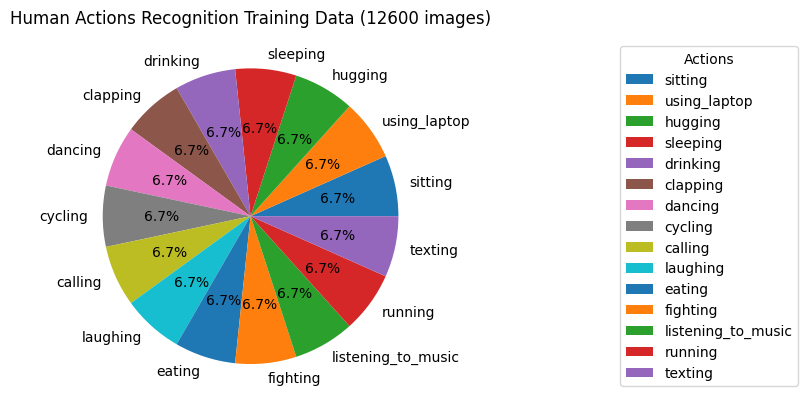

In [23]:
# Visualizing the training data and its categories:
actions = train_df.label.value_counts()
fig1, ax = plt.subplots()
ax.pie(actions.values, labels = actions.index, autopct='%1.1f%%')

# Add title
ax.set_title("Human Actions Recognition Training Data (12600 images)")

# Show legend
ax.legend(title="Actions",bbox_to_anchor=[2,0.5], loc="center right")

# Show chart
fig1.show()

### Examples of Images In Each Class

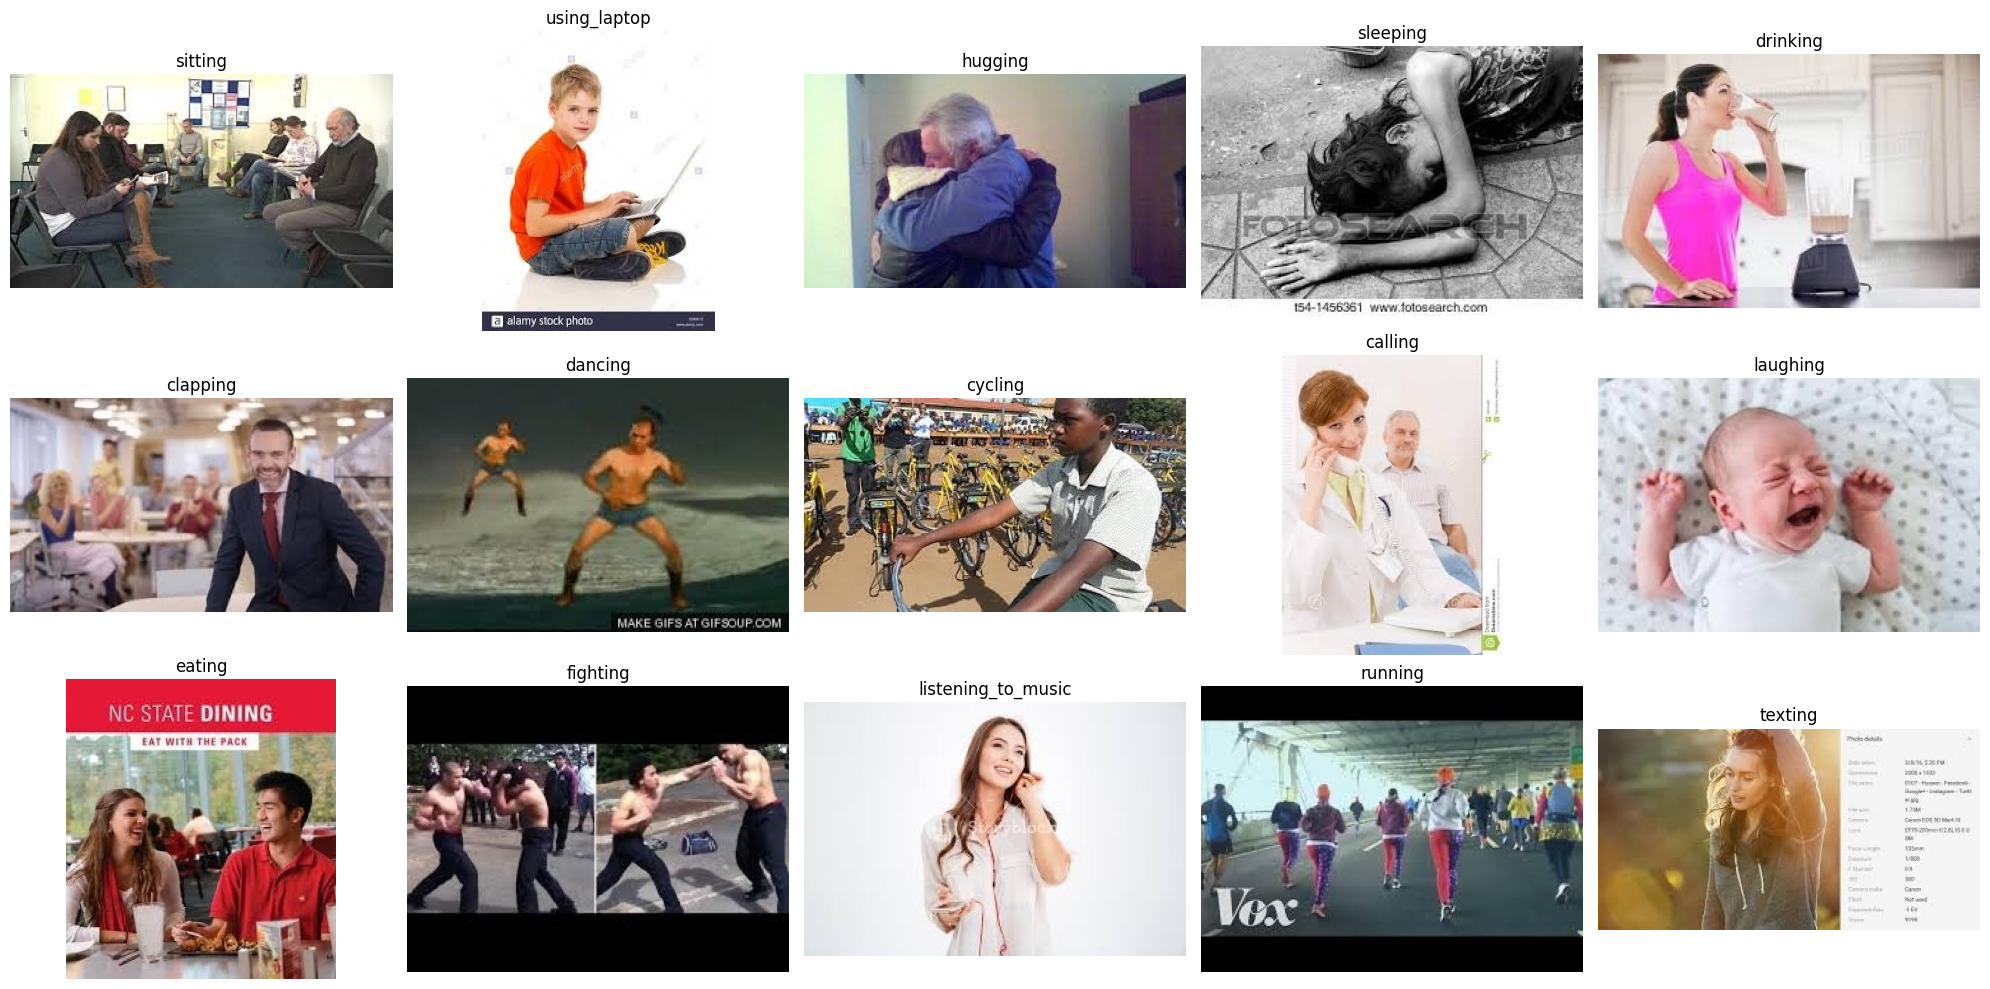

In [ ]:
# Images from each class
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
train_set_images = "Human Action Recognition/train"
for axis, class_name in enumerate(train_df['label'].unique()):
    class_images = train_df[train_df['label'] == class_name]['filename'].values
    img = plt.imread(os.path.join(train_set_images, class_images[random.randrange(0, 841)]))
    axes[axis].imshow(img)
    axes[axis].set_title(class_name)
    axes[axis].axis('off')
plt.tight_layout()
plt.show()

### Data Preprocessing and Set Creation

In [ ]:

train_set_images = "Human Action Recognition/train"

train_df['label'] = train_df['label'].astype('category')
train_df['label'] = train_df['label'].cat.codes
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_set_images, x))

train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=2)

def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_set['filepath'].values, train_set['label'].values))
train_dataset = train_dataset.map(load_image).batch(32).shuffle(buffer_size=len(train_set))

val_dataset = tf.data.Dataset.from_tensor_slices((val_set['filepath'].values, val_set['label'].values))
val_dataset = val_dataset.map(load_image).batch(32)



### Creating the model:

In [ ]:
# Create the model:
# Consider adding pre-trained model imagenet
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\espa8\Downloads\CS4200 Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Look at model layers, output shape, and parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Train the model:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)

Epoch 1/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 56s 154ms/step - accuracy: 0.0958 - loss: 2.7070 - val_accuracy: 0.2004 - val_loss: 2.4513
Epoch 2/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 49s 145ms/step - accuracy: 0.1984 - loss: 2.4325 - val_accuracy: 0.2758 - val_loss: 2.2695
Epoch 3/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 53s 156ms/step - accuracy: 0.2824 - loss: 2.2085 - val_accuracy: 0.3123 - val_loss: 2.1514
Epoch 4/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 49s 145ms/step - accuracy: 0.3610 - loss: 1.9849 - val_accuracy: 0.3286 - val_loss: 2.1095
Epoch 5/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 46s 141ms/step - accuracy: 0.4217 - loss: 1.7780 - val_accuracy: 0.3464 - val_loss: 2.0621
Epoch 6/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.4945 - loss: 1.5573 - val_accuracy: 0.3437 - val_loss: 2.1268
Epoch 7/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step - accuracy: 0.5690 - loss: 1.3283 - val_accuracy: 0.3520 - val_loss: 2.1992
Epoch 8/15
315/315 ━━━━━━━━━━━━━━━━━━━━ 48s 145ms/step - accuracy: 0.6410 - loss: 1

In [ ]:
# Save model
model.save('model/HAR4200model.keras')

### Check Accuracy and Loss

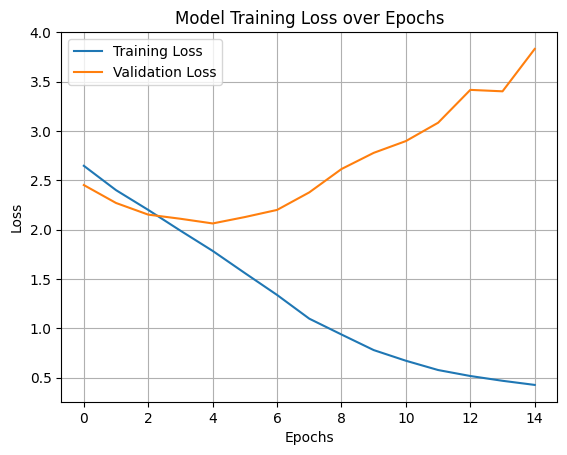

In [68]:
fig, ax = plt.subplots()
loss_graph = history.history["loss"]
loss_val_graph = history.history["val_loss"]
ax.plot(loss_graph, label="Training Loss")
ax.plot(loss_val_graph, label="Validation Loss")
ax.set(xlabel="Epochs", ylabel="Loss",
       title="Model Training Loss over Epochs")
ax.grid()
ax.legend(loc="upper left")
plt.show()


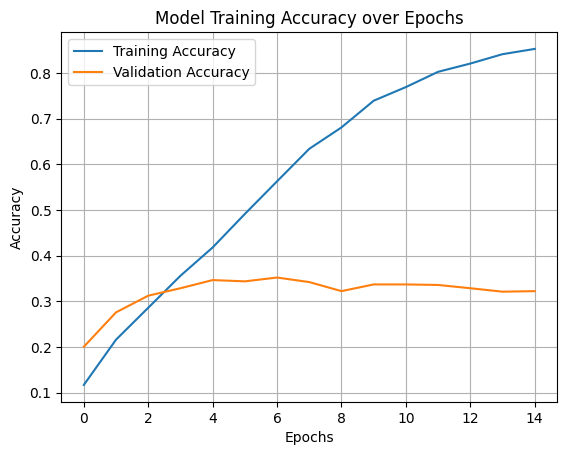

In [69]:
fig, ax = plt.subplots()
accuracy_graph = history.history["accuracy"]
accuracy_val_graph = history.history["val_accuracy"]
ax.plot(accuracy_graph, label="Training Accuracy")
ax.plot(accuracy_val_graph, label="Validation Accuracy")
ax.set(xlabel="Epochs", ylabel="Accuracy",
       title="Model Training Accuracy over Epochs")
ax.grid()
ax.legend(loc="upper left")
plt.show()


### Testing the Model

In [ ]:
# Run this cell if model is already trained
model_path = "model/HAR4200model.keras"
model_running = tf.keras.models.load_model(model_path)

val_predictions = np.argmax(model_running.predict(val_dataset), axis=-1)
val_labels = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


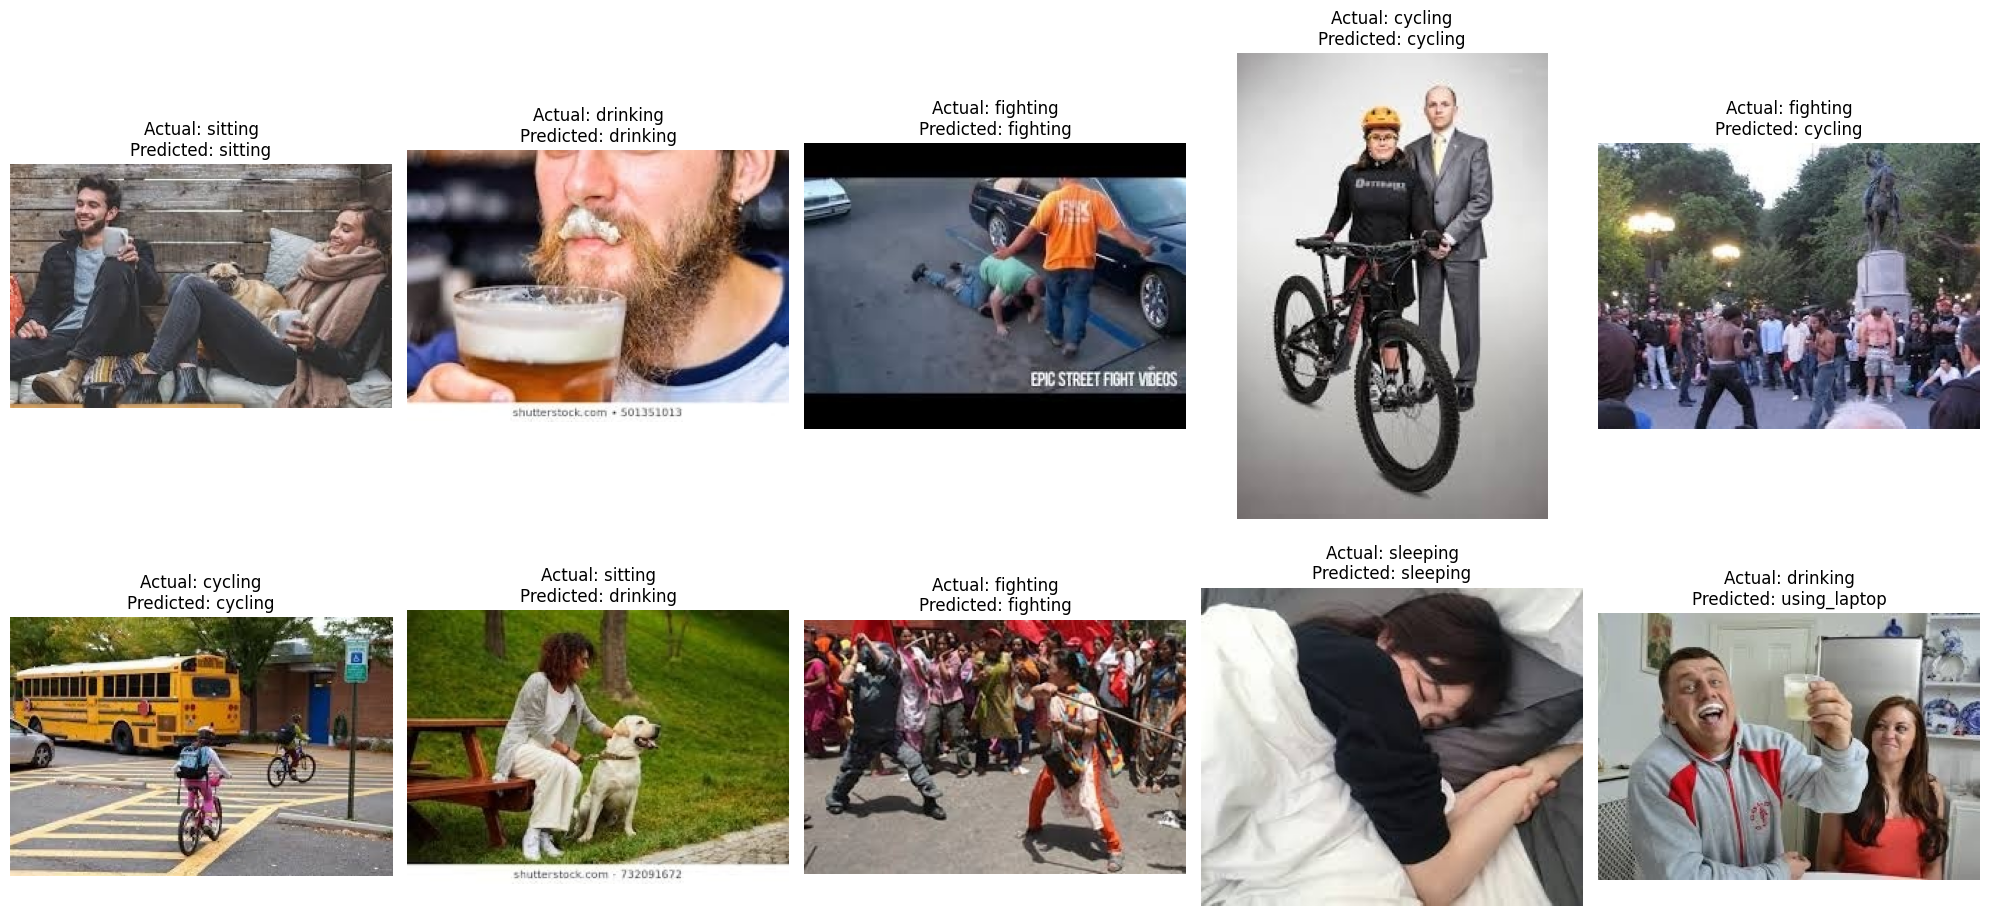

In [14]:
# Predicting images that show actual and predicted labels from the validation set
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
sampled_val_set = val_set.sample(10)
for i, (index, row) in enumerate(sampled_val_set.iterrows()):
    img = plt.imread(row['filepath'])
    actual_label = categories[row['label']]
    predicted_label = categories[val_predictions[val_set.index.get_loc(index)]]
    axes[i].imshow(img)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### Attempt with Pretrained Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split


# Obtain training data
train_set_path = "Human Action Recognition/Training_set.csv"
train_df = pd.read_csv(train_set_path)

# Store the original categories
categories = train_df['label'].astype('category').cat.categories

In [2]:
# Create second model utilizing pre-trained model
model2 = Sequential()
pretrained = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', pooling='avg', classes=15, input_shape=(128, 128, 3))

for layer in model2.layers:
    layer.trainable=False

model2.add(pretrained)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(15, activation='softmax'))

In [7]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,644,495 (94.01 MB)

 Trainable params: 24,591,375 (93.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Data pre-processing

train_set_images = "Human Action Recognition/train"

train_df['label'] = train_df['label'].astype('category')
train_df['label'] = train_df['label'].cat.codes
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_set_images, x))

train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=2)

def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_set['filepath'].values, train_set['label'].values))
train_dataset = train_dataset.map(load_image).batch(32).shuffle(buffer_size=len(train_set))

val_dataset = tf.data.Dataset.from_tensor_slices((val_set['filepath'].values, val_set['label'].values))
val_dataset = val_dataset.map(load_image).batch(32)



In [11]:
history2 = model2.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.2816 - loss: 2.3091 - val_accuracy: 0.0667 - val_loss: 4.9284
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.4888 - loss: 1.5615 - val_accuracy: 0.0607 - val_loss: 3.4556
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.5918 - loss: 1.2571 - val_accuracy: 0.2389 - val_loss: 3.1410
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.6905 - loss: 0.9571 - val_accuracy: 0.3619 - val_loss: 2.5274
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7698 - loss: 0.7091 - val_accuracy: 0.4274 - val_loss: 2.0857
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8445 - loss: 0.4768 - val_accuracy: 0.3306 - val_loss: 2.8883
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.8989 - loss: 0.3117 - val_accuracy: 0.3595 - val_loss: 2.8768
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.9157 - loss: 0.2521 - val_accu

In [ ]:
# Save model
model2.save('2ndHAR4200model.keras')

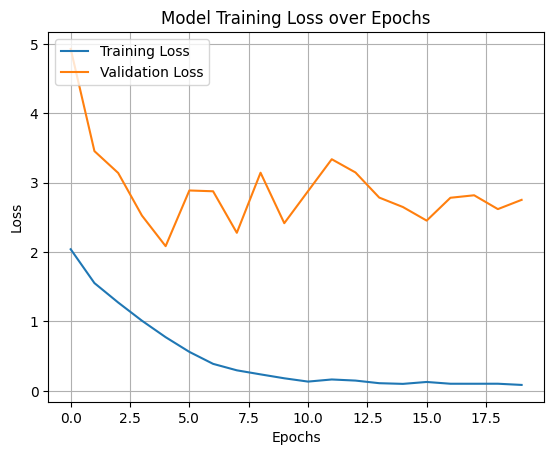

In [13]:
fig, ax = plt.subplots()
loss_graph = history2.history["loss"]
loss_val_graph = history2.history["val_loss"]
ax.plot(loss_graph, label="Training Loss")
ax.plot(loss_val_graph, label="Validation Loss")
ax.set(xlabel="Epochs", ylabel="Loss",
       title="Model Training Loss over Epochs")
ax.grid()
ax.legend(loc="upper left")
plt.show()

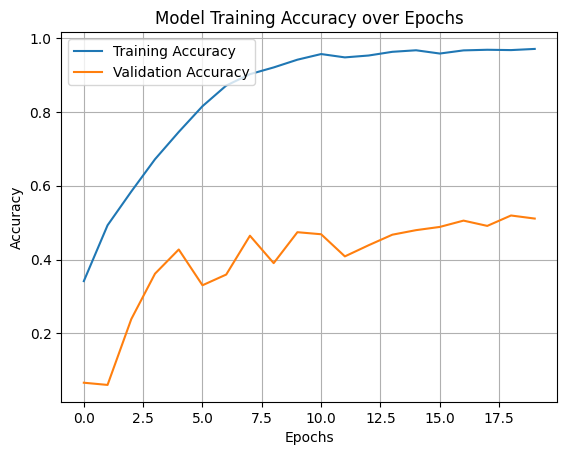

In [14]:
fig, ax = plt.subplots()
accuracy_graph = history2.history["accuracy"]
accuracy_val_graph = history2.history["val_accuracy"]
ax.plot(accuracy_graph, label="Training Accuracy")
ax.plot(accuracy_val_graph, label="Validation Accuracy")
ax.set(xlabel="Epochs", ylabel="Accuracy",
       title="Model Training Accuracy over Epochs")
ax.grid()
ax.legend(loc="upper left")
plt.show()

In [ ]:
model_path = "2ndHAR4200model.keras"
model_running = tf.keras.models.load_model(model_path)

val_predictions = np.argmax(model_running.predict(val_dataset), axis=-1)
val_labels = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step


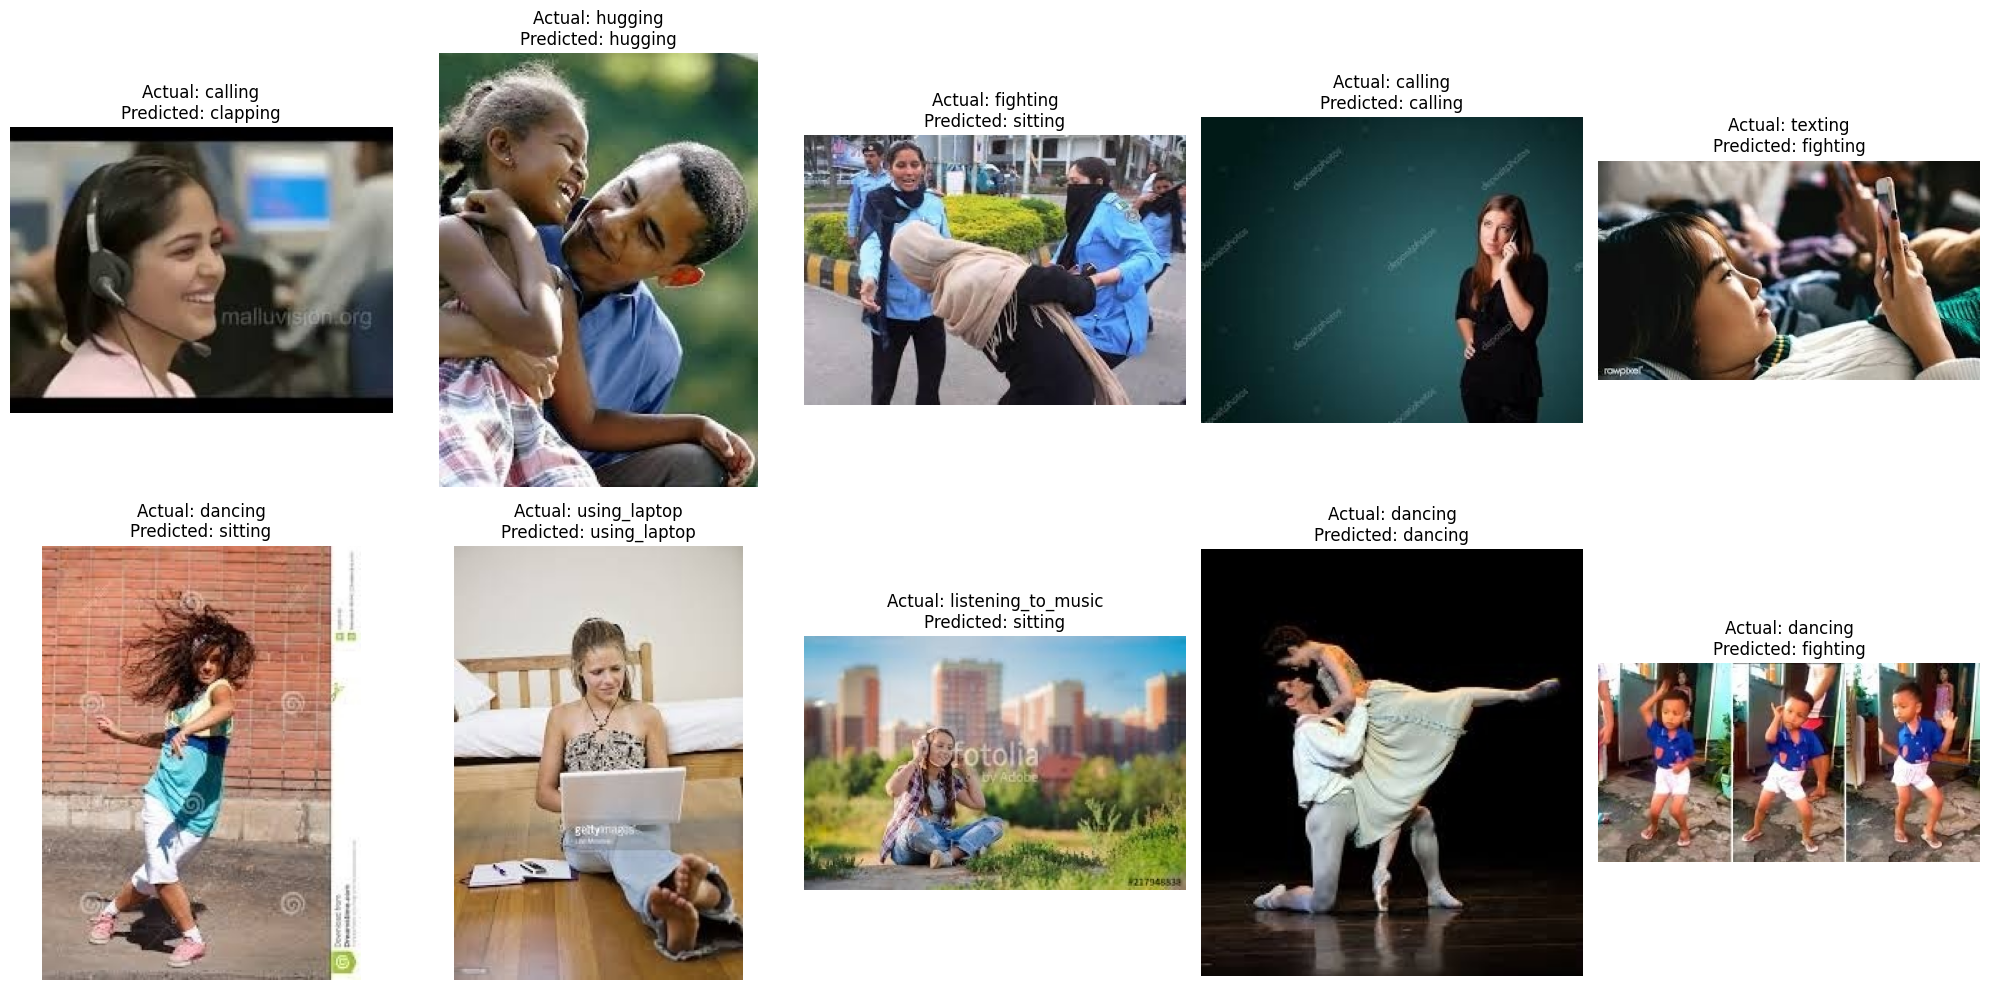

In [6]:
# Predicting images that show actual and predicted labels from the validation set
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
sampled_val_set = val_set.sample(10)
for i, (index, row) in enumerate(sampled_val_set.iterrows()):
    img = plt.imread(row['filepath'])
    actual_label = categories[row['label']]
    predicted_label = categories[val_predictions[val_set.index.get_loc(index)]]
    axes[i].imshow(img)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### If Model Is Trained Already

In [ ]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split

# Obtain test data
test_set_path = "Human Action Recognition/Testing_set.csv"
test_df = pd.read_csv(test_set_path)

# Uncomment below if you wanna run old model
#model_path = "HAR4200model.keras"
model_path = "2ndHAR4200model.keras"
model_running = tf.keras.models.load_model(model_path)

# Get categories from training data
# Obtain training data
train_set_path = "Human Action Recognition/Training_set.csv"
train_df = pd.read_csv(train_set_path)

# Store the original categories
categories = train_df['label'].astype('category').cat.categories


# Prepare test data
test_set_images = "Human Action Recognition/test"
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_set_images, x))

test_dataset = tf.data.Dataset.from_tensor_slices(test_df['filepath'].values)
test_dataset = test_dataset.map(lambda x: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), [128, 128]) / 255.0)).batch(32)


In [2]:
# Predict on test set
test_predictions = np.argmax(model_running.predict(test_dataset), axis=-1)
test_df['label'] = test_predictions

169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 321ms/step


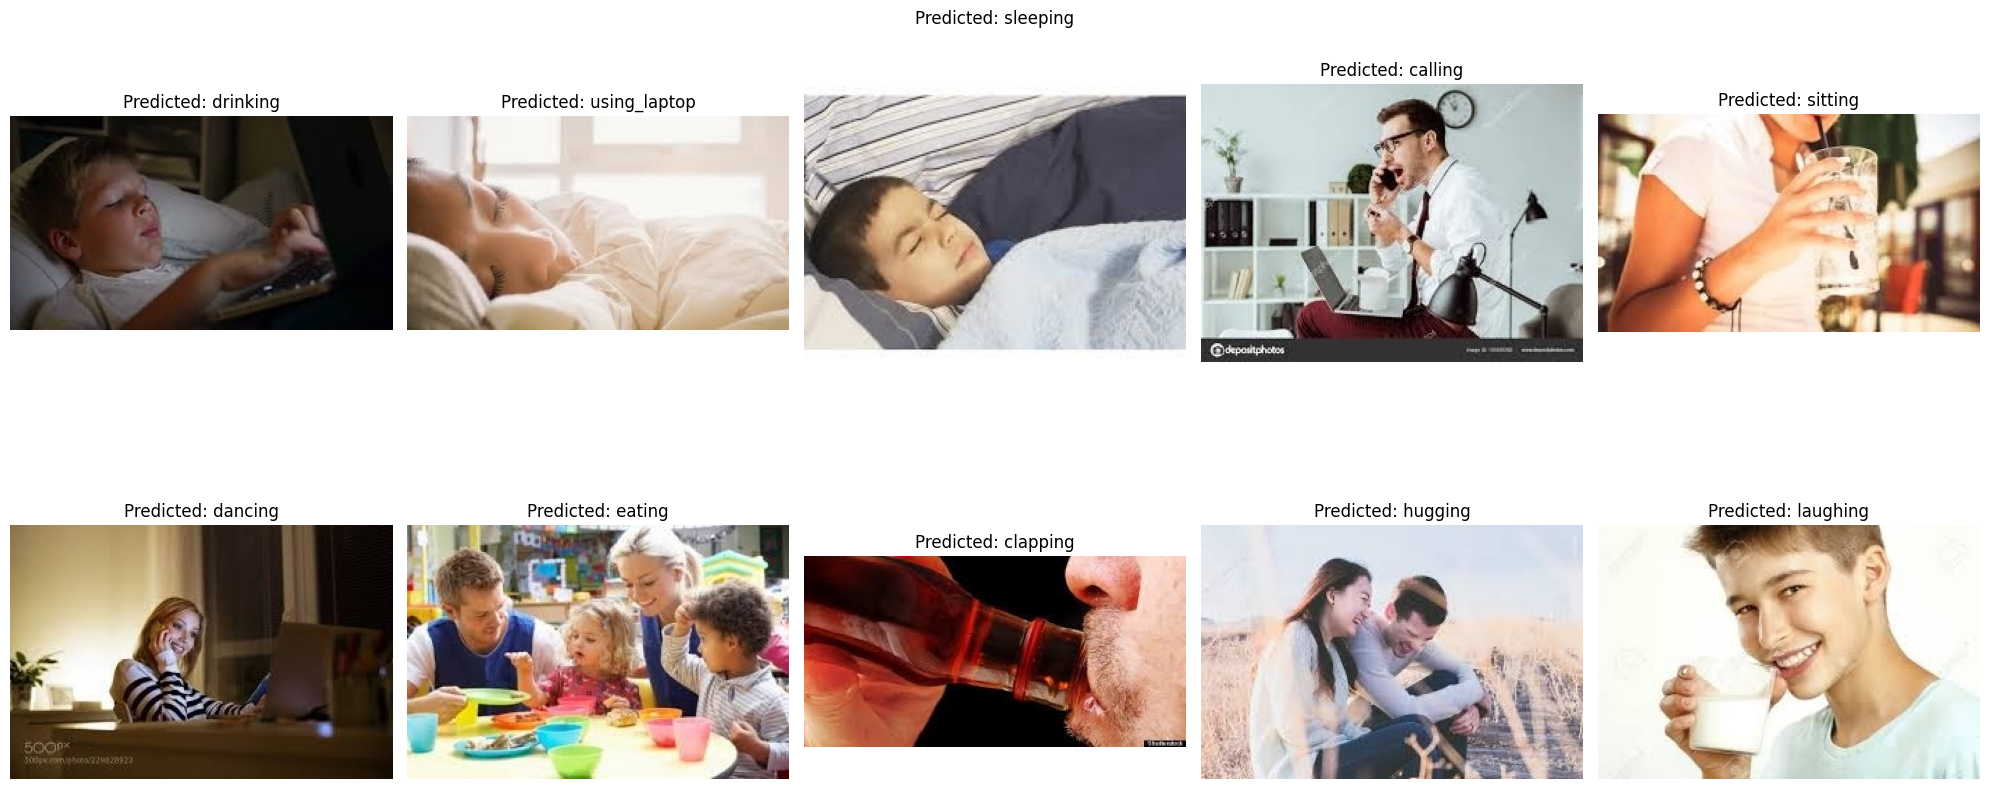

In [6]:
# Predicting images that show predicted labels from the test set
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
sampled_test_set = test_df.sample(10)
for i, (index, row) in enumerate(sampled_test_set.iterrows()):
    img = plt.imread(row['filepath'])
    predicted_label = categories[test_predictions[test_df.index.get_loc(index)]]
    axes[i].imshow(img)
    axes[i].set_title(f"Predicted: {predicted_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()